In [1]:
import numpy as np
import itertools
import trimesh
import math
import k3d
from time import sleep

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [3]:
NUM_POINTS = 10


plot = k3d.plot(name='points')
plot.display()

model = Model("./data/Dude.obj")
model.generate_view_points(NUM_POINTS)

observations = []
for view_point_idx in range(NUM_POINTS):
    observation = model.get_observation(view_point_idx)
    
    plot = observation.illustrate(plot, size=0.04)
    plot = illustrate_points([model.get_point(view_point_idx)], size=1.0, plot=plot)
    sleep(2)
    
    observations.append(observation)
    
combined_observation = combine_observations(observations)
reconstructed_vertices, reconstructed_faces = get_mesh(combined_observation)

loss = model.surface_similarity(reconstructed_vertices, reconstructed_faces)
print(loss)

illustrate_mesh(reconstructed_vertices, reconstructed_faces)

Output()

unable to load materials from: FinalBaseMesh.mtl
specified material (default)  not loaded!
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-30b1dabedaf0>", line 12, in <module>
    observation = model.get_observation(view_point_idx)
  File "/tf/NextBestViewRL/geometry/model.py", line 154, in get_observation
    observation = self.raycast()
  File "/tf/NextBestViewRL/geometry/model.py", line 134, in raycast
    mesh_face_indexes) = self.raycaster.get_image(self.mesh)
  File "/tf/NextBestViewRL/geometry/utils/raycasting.py", line 25, in get_image
    mesh, self.rays_origins, self.rays_directions)
  File "/tf/NextBestViewRL/geometry/utils/raycasting.py", line 105, in ray_cast_mesh
    multiple_hits=False, return_locations=True)
  File "/opt/conda/lib/python3.7/site-packages/trimesh/constants.py", line 134, in timed
    result = method(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/trimesh/ray/r

KeyboardInterrupt: 

## Environment

In [2]:
import gym
from gym import spaces

from pypoisson import poisson_reconstruction


MAX_POINS_CNT = int(1e6)
VIEW_POINTS_CNT = 10
MEMORY_SIZE = 10


class EnvError(Exception):
    pass


class Environment(gym.Env):
    def __init__(self,
                 number_of_view_points=VIEW_POINTS_CNT,
                 similarity_threshold=0.95,
                 illustrate=False):
        super().__init__()

        self.number_of_view_points = number_of_view_points
        self.illustrate = illustrate

        self.action_space = spaces.Discrete(number_of_view_points)
        
        image_size = 512 # model.raycaster.resolution_image

        self.observation_space = spaces.Dict({
            'points':  spaces.Box(-np.inf, np.inf, (MAX_POINS_CNT, 3), dtype=np.float32),
            # 'normals': spaces.Box(-np.inf, np.inf, (MAX_POINS_CNT, 3), dtype=np.float32),
            # 'vertex_indexes': spaces.Box(-np.inf, np.inf, (MAX_POINS_CNT, 3), dtype=np.int32),
            # 'face_indexes': spaces.Box(-np.inf, np.inf, (MAX_POINS_CNT, 3), dtype=np.int32),
            'depth_map': spaces.Box(-np.inf, np.inf, (MEMORY_SIZE, image_size, image_size), dtype=np.float32),
            # 'normals_image': spaces.Box(-np.inf, np.inf, (VIEW_POINTS_CNT, image_size, image_size), dtype=np.float32)
        })

        self._similarity_threshold = similarity_threshold
        self._reconstruction_depth = 10

        self.model = None
        self.plot = None

    def reset(self):
        """
        Reset the environment for new episode.
        Randomly (or not) generate CAD model for this episode.
        """
        self.model = Model("./data/Tetrahedron.obj")
        self.model.generate_view_points(self.number_of_view_points)
        
        if self.illustrate:
            self.model.illustrate().display()
        
        init_state = self.action_space.sample()
        observation = self.model.get_observation(init_state)
        return observation

    def step(self, action):
        """
        Get new observation from current position (action), count step reward, decide whether to stop.
        Args:
            action: int
        return: 
            next_state: List[List[List[int, int, int]]]
            reward: float
            done: bool
            info: Tuple
        """
        assert env.action_space.contains(action)
        observation = self.model.get_observation(action)

        reward = self.step_reward(observation)
        done = reward >= self._similarity_threshold

        return observation, reward, done, {}
    
    def render(self, action, observation, plot=None):
        if plot is None:
            plot = self.plot
            
        plot = illustrate_points(
           [self.model.get_point(action)], size=0.5, plot=plot)
        
        plot = observation.illustrate(plot, size=0.03)
        return plot
    
    def step_reward(self, observation):
        # THINK ABOUT yet another reward
        return self.model.observation_similarity(observation)
    
    def final_reward(self, observation):
        vertices, faces = self._get_mesh(observation)
        reward = self.model.surface_similarity(vertices, faces)
        
        if self.illustrate:
            illustrate_mesh(vertices, faces).display()
        return reward
        
    def _get_mesh(self, observation):
        faces, vertices = poisson_reconstruction(observation.points,
                                                 observation.normals,
                                                 depth=self._reconstruction_depth)
        return vertices, faces

    
class CombiningObservationsWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
        self._similarity_threshold = env._similarity_threshold

        self.combined_observation = None
        self.plot = None
    
    def reset(self):
        observation = self.env.reset()
        self.combined_observation = observation
        
        if self.env.illustrate:
            self.plot = k3d.plot(name='wrapper')
            self.plot.display()
        return self.combined_observation
  
    def step(self, action):
        observation, reward, done, info = self.env.step(action)

        self._combine_observations(observation)

        combined_reward = self.env.step_reward(self.combined_observation)
        done = done or combined_reward >= self._similarity_threshold
        
        new_reward = combined_reward - reward
        print(combined_reward, new_reward, reward)
        return self.combined_observation, new_reward, done, info

    def render(self, action, observation):
        self.plot = self.env.render(action, observation, self.plot)
        
    def final_reward(self):
        return self.env.final_reward(self.combined_observation)
    
    def _combine_observations(self, observation):
        if self.combined_observation is None:
            raise EnvError("Environment wasn't reset")
        
        self.combined_observation += observation


class StepPenaltyRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
        
        self._similarity_reward_weight = 1.0
            
    def reward(self, reward):
        # THINK ABOUT
        reward = -1 + self._similarity_reward_weight * reward
        return reward
    
    def render(self, action, observation):
        self.env.render(action, observation)
        
    def final_reward(self):
        return self.env.final_reward()

    
class DepthMapWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        
        self.observation_space = self.observation_space['depth_map']
        self.image_size = self.observation_space.shape[1]
        self.memory_size = self.observation_space.shape[0]
        
        self.last_observation = None

    def reset(self):
        observation = self.env.reset()
        return self.observation(observation)

    def observation(self, observation):
        self.last_observation = observation

        depth_map = observation.depth_map
        assert depth_map.ndim == 3

        new_size = self.memory_size - depth_map.shape[0]
        if new_size >= 0:
            depth_map = np.pad(depth_map,
                               ((0,new_size),(0,0), (0,0)),
                               mode='constant')
        else:
            depth_map = depth_map[-new_size:]
            
        return depth_map
    
    def render(self, action, observation):
        if self.last_observation is not None:
            self.env.render(action, self.last_observation)
    
    def final_reward(self):
        return self.env.final_reward()

        
        
# TODO one more wrapper for GPU (observation, reward -> tensor)

## RandomAgent

In [3]:
class RandomAgent:

    def __init__(self, env):
        self.env = env
        
        # self.observation_size = env.observation_space.shape[0]
        self.actions_cnt = env.action_space.n
        
        self._max_iter = 2
        self._gamma = 0.99
        self._final_reward_weight = 1.0
  

    def predict_action(self, state):
        """
        Return action that should be done from input state according to current policy.
        Args:
            state: list of points - results of raycasting
        return: 
            action: int
        """    
        # some cool RL staff
        return self.env.action_space.sample()
    

    def evaluate(self):
        """
        Generate CAD model, reconstruct it and count the reward according   to MSE between original and reconstructed models and number of steps.
        Args:
            environment: Environment
            max_iter: int - max number of iterations to stop (~15)
            gamma: float - discounted factor
            w: float - weight of mse to final episode reward
        return: 
            episode_reward: float
        """    
        
        state = self.env.reset()
        episode_reward = 0.0
        states = []
        for t in range(self._max_iter):
            action = self.predict_action(state)
            state, reward, done, info = self.env.step(action)
            print("REWARD: ", reward)
            states.append(state)
            self.env.render(action, state)
            episode_reward += reward * self._gamma ** t

            if done:
                break
        
        final_reward = self.env.final_reward()
        print("Hausdorff reward: ", final_reward)
        episode_reward += self._final_reward_weight / final_reward # QUESTION
        return episode_reward, states


In [4]:
env = Environment(illustrate=False)
env = CombiningObservationsWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = DepthMapWrapper(env)

agent = RandomAgent(env)

In [5]:
# reward, states = agent.evaluate()
# print("FINAL REWARD: ", reward)

## DQN

In [6]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [7]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

### Replay buffer

In [8]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)



### Epsilon-greedy

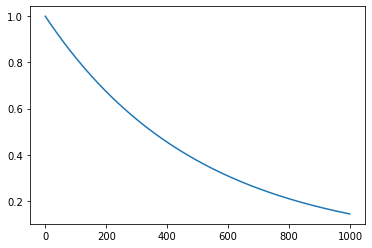

In [13]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(1000)])

### DQN

In [14]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action
    
    
    
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        # TODO action input
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # concat with action_num
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
            print("Action: ", action)
        else:
            action = random.randrange(env.action_space.n)
            print("Action: ", action, "(random)")
        return action

In [15]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = torch.mean((q_value - expected_q_value.detach()) ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [16]:
env = Environment(illustrate=False)
env = CombiningObservationsWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = DepthMapWrapper(env)

In [17]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.001)

replay_initial = 5
replay_buffer = ReplayBuffer(20)

In [18]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

### Training

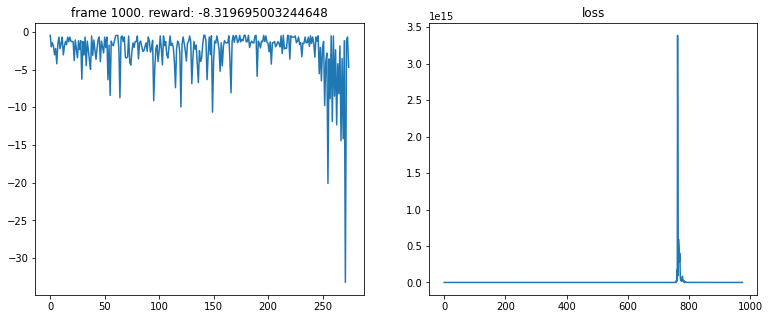

In [19]:
num_frames = 1000
batch_size = 4
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
nof_vp = 0
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    # QUESTION episode_reward += reward * self._gamma ** t

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
#         final_reward = env.final_reward()
#         print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()
        
        state = env.reset()
        nof_vp = 0
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
#         print("Computing loss")
        loss = compute_td_loss(batch_size)
#         print(loss)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, "./models/triangle-10vp.pt")

In [23]:
torch.save(model, "./models/triangle-10vp.pt")

In [28]:
env = Environment(illustrate=True)
env = CombiningObservationsWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = DepthMapWrapper(env)

In [ ]:
max_iter = 100

state = env.reset()
episode_reward = 0.0
states = []
for t in range(max_iter):
    action = model.act(state, epsilon=0.0)
    state, reward, done, info = env.step(action)
    print("REWARD: ", reward)
    states.append(state)
    env.render(action, state)
    episode_reward += reward

    if done:
        break

final_reward = env.final_reward()
print("Hausdorff reward: ", final_reward)
episode_reward += 1.0 / final_reward


Output()

Output()

Action:  1
0.7649794505732208 0.23534501406013408 0.5296344365130867
REWARD:  -0.7646549859398659
Action:  6
0.7660609993510707 0.2966147523253299 0.46944624702574084
REWARD:  -0.70338524767467
Action:  6
0.7660609993510707 0.2966147523253299 0.46944624702574084
REWARD:  -0.70338524767467
Action:  6
0.7660609993510707 0.2966147523253299 0.46944624702574084
REWARD:  -0.70338524767467
Action:  6
0.7660609993510707 0.2966147523253299 0.46944624702574084
REWARD:  -0.70338524767467
Action:  6
0.7660609993510707 0.2966147523253299 0.46944624702574084
REWARD:  -0.70338524767467
Action:  6
0.7660609993510707 0.2966147523253299 0.46944624702574084
REWARD:  -0.70338524767467
Action:  7
0.7660609993510707 0.23750811161583385 0.5285528877352369
REWARD:  -0.7624918883841661
Action:  7
0.7660609993510707 0.23745403417694144 0.5286069651741293
REWARD:  -0.7625459658230586
Action:  7
0.7660609993510707 0.23750811161583385 0.5285528877352369
REWARD:  -0.7624918883841661
Action:  6
0.7660609993510707 0.

In [31]:
episode_reward

-2.2363852743564823